In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from circle_fit import taubinSVD
from tqdm import tqdm
import MDAnalysis as mda
from src.utils_py.auxil import *
from scipy.optimize import minimize

---

In [2]:
plt.rcParams['font.family'] = 'Helvetica'

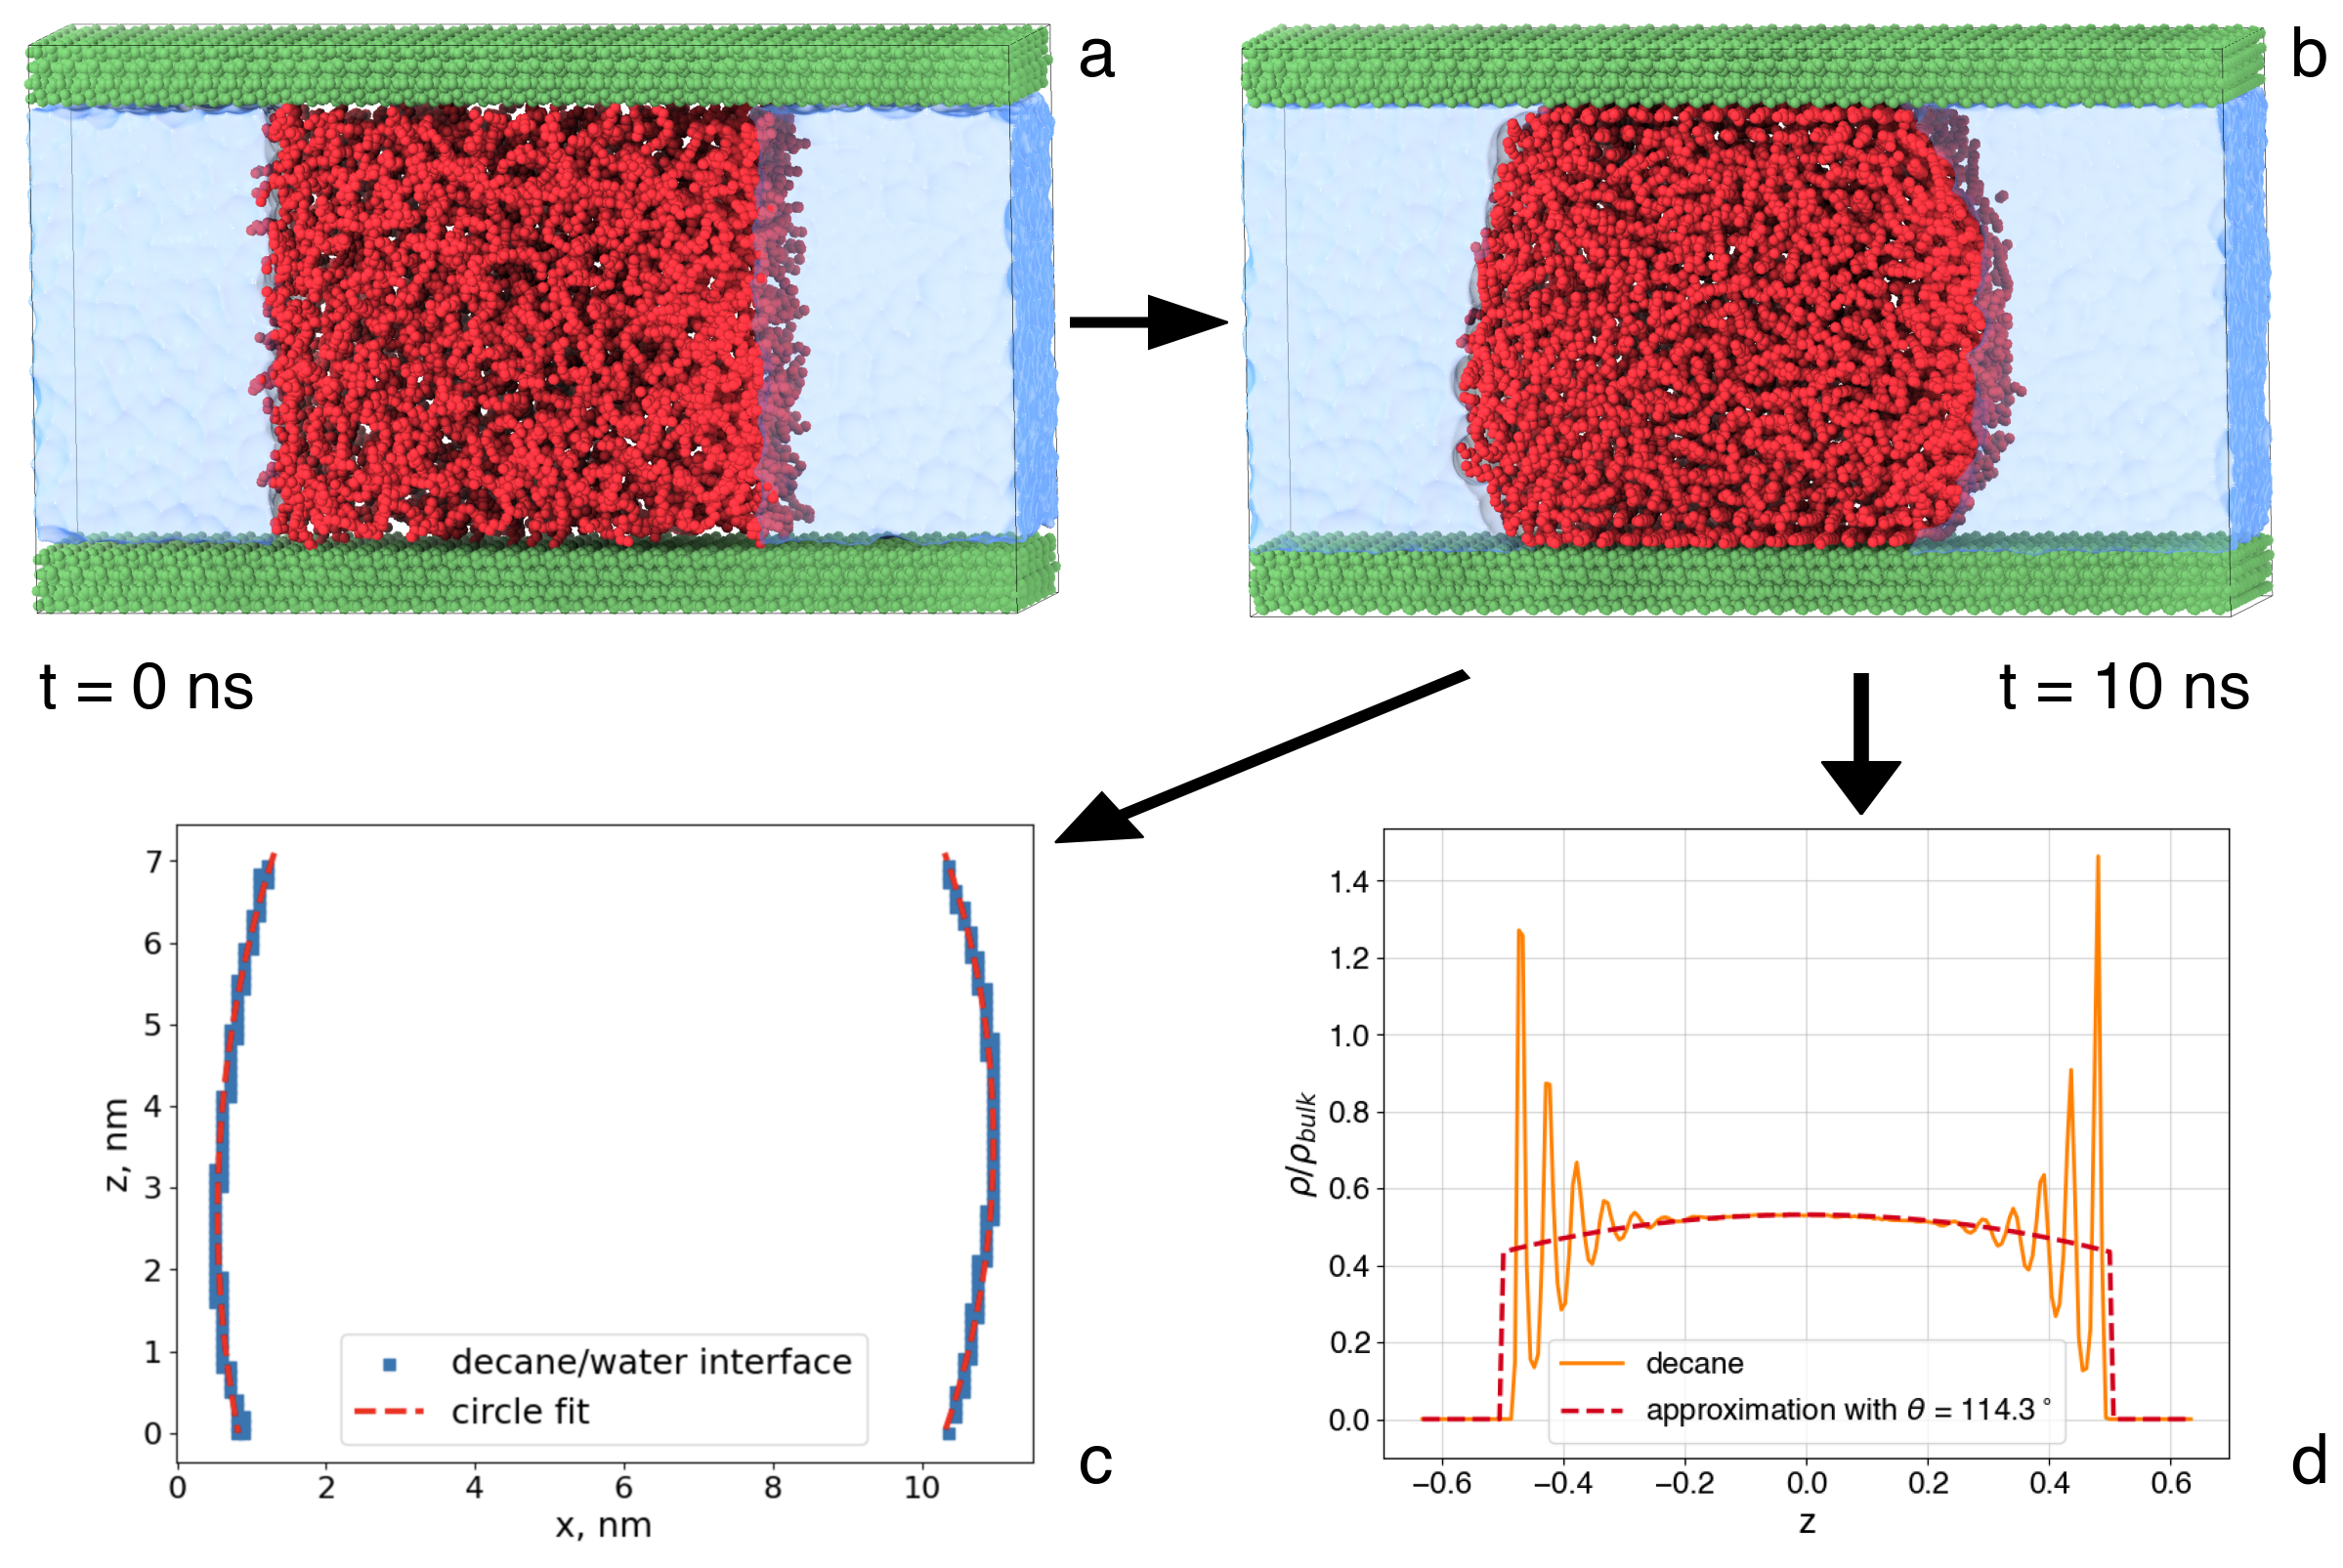

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the four images
# img1 = mpimg.imread('calcite_decane_water_init.png')  # Replace with your first image path
# img2 = mpimg.imread('calcite_decane_water.png')  # Replace with your second image path
img1 = mpimg.imread('cal_decane_init.png')  # Replace with your first image path
img2 = mpimg.imread('cal_decane.png')  # Replace with your second image path
img3 = mpimg.imread('calcite_decane_water_angle_approx.png')  # Replace with your third image path
img4 = mpimg.imread('calcite_decane_water_profile_approx.png')  # Replace with your fourth image path

# Create a new figure
fig, ax = plt.subplots(figsize=(18, 12), dpi=150)
plt.axis('off')  # Turn off the axis for the main plot as well

# Define positions for the four subplots
positions = [(0.05, 0.55, 0.4, 0.4),  # Top-left image (t = 0 ps)
             (0.51, 0.55, 0.4, 0.4),  # Top-right image (t = 10 ps)
             (0.05, 0.05, 0.42, 0.42),  # Bottom-left plot
             (0.5, 0.05, 0.42, 0.42)]  # Bottom-right plot

# Images to plot
images = [img1, img2, img3, img4]

# Add each image to the figure in the defined positions
for i, (pos, img) in enumerate(zip(positions, images)):
    ax_inset = fig.add_axes(pos)
    ax_inset.imshow(img)
    ax_inset.axis('off')

# Draw arrows
# plt.arrow(0.44, 0.55, 0.05, 0, width=0.001, head_width=0.01, head_length=0.01, fc='black', ec='black')
# plt.arrow(0.32, 0.52, -0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')
# plt.arrow(0.68, 0.52, 0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')

ax.arrow(0.4, 0.75, 0.08, 0, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.6, 0.55, -0.13, -0.08, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.75, 0.55, 0, -0.05, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)

# Add text annotations
ax.text(0.1, 0.54, "t = 0 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)
ax.text(0.85, 0.54, "t = 10 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)

# Add labels (a, b, c, d) in the bottom right corner of each image
label_positions = [(0.46, 0.9),  # Bottom-right corner of the top-left image
                   (0.92, 0.9),  # Bottom-right corner of the top-right image
                   (0.46, 0.1),  # Bottom-right corner of the bottom-left image
                   (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

labels = ['a', 'b', 'c', 'd']

# Add each label to the figure
for label, (x, y) in zip(labels, label_positions):
    fig.text(x, y, label, fontsize=34, ha='center', va='center', transform=fig.transFigure)


# plt.savefig('steps.png', dpi=150)
plt.show()


---

## Graphical abstract

In [4]:
plt.rcParams['font.family'] = 'Helvetica'

In [7]:
structure = read_gro(f'data/cal_dw_1340_14458.gro')

rho_bulk = 3.0896 * 10

H = 9.0
l = structure.box[0] / H
phi = 0.5
print('l:', l)
print('H:', H)

z, dens = np.loadtxt(f'data/dens_cal.xvg', comments=["@", "#"], unpack=True)

dens /= rho_bulk
zeta = z / H

print('real phi:', np.trapz(dens, zeta))

left, right = 0, len(zeta)
for i in range(len(zeta)):
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    if zeta[i] < 0.5:
        right = i+1
        break

def L1(x, zeta, dens, l, phi):
    return np.sum(np.abs(rho_roll_theta(zeta, l, phi, x[0]) + x[1] - dens))

x0 = [3*np.pi/4, 0]
res = minimize(L1, x0, (zeta[left:right], dens[left:right], l, phi), method = 'Nelder-Mead', bounds=((np.pi / 2, np.pi), (0, 0)), options={'disp': True})
best = {'theta': res.x[0], 'offset': res.x[1]}

print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))

l: 2.2227777777777775
H: 9.0
real phi: 0.4998787243386846
Optimization terminated successfully.
         Current function value: 12.686230
         Iterations: 20
         Function evaluations: 39
angle: 114.3
offset: 0.00


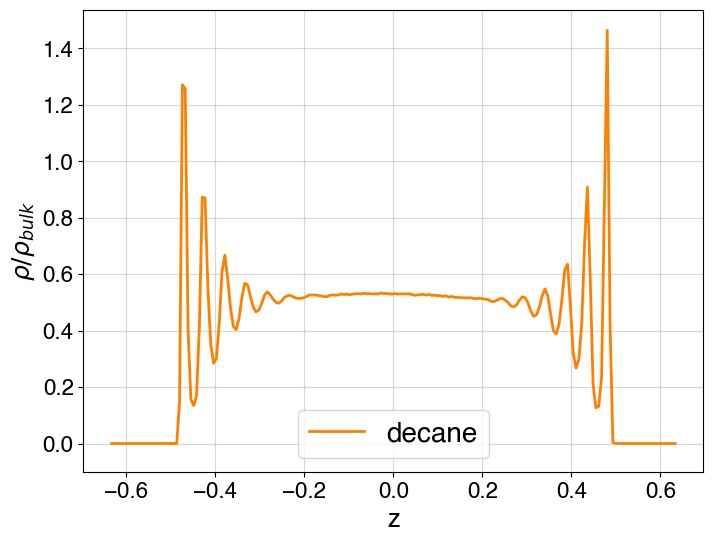

In [10]:
plt.figure(figsize=(8, 6))

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='decane',
    color='#FF8000',
    # color='#40BFBF',
    linewidth=2
)

# plt.plot(
#     zeta, rho_roll_theta(zeta, l, phi, best['theta']) + best['offset'],
#     label=r'approximation with $\theta$ = {:.1f}$^\circ$C'.format(np.rad2deg(best["theta"])),
#     # color='#00B400',
#     color='#D2001B',
#     linewidth=2.5,
#     linestyle='dashed'
# )

plt.xlabel('z', fontsize=18)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower center', fontsize=20)
plt.ylim(bottom=-0.1)
# plt.savefig('img/density_profile_calcite_decane.png')
plt.show()

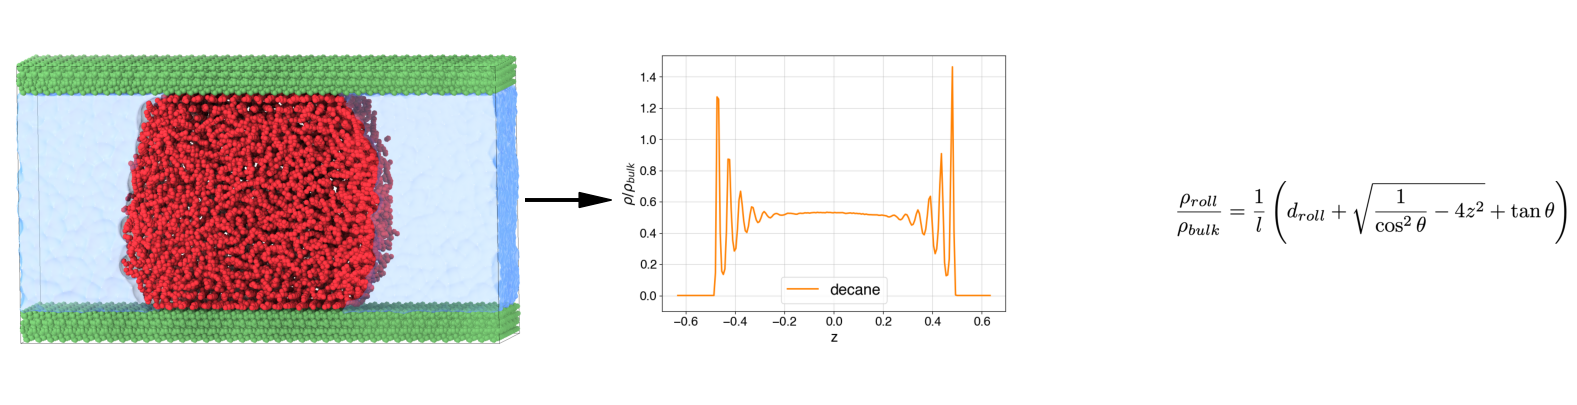

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the four images
img1 = mpimg.imread('cal_decane.png')  # Replace with your second image path
# img3 = mpimg.imread('calcite_decane_water_profile_approx.png')  # Replace with your fourth image path
img2 = mpimg.imread('calcite_decane_water_profile.png')  # Replace with your fourth image path
img3 = mpimg.imread('rho_roll.png')

# Create a new figure
fig, ax = plt.subplots(figsize=(13, 5), dpi=100)
plt.axis('off')  # Turn off the axis for the main plot as well

# Define positions for the four subplots
positions = [(0.00, 0.2, 0.5, 0.5),  # Top-left image (t = 0 ps)
             (0.42, 0.2, 0.6, 0.6),  # Top-right image (t = 10 ps)
             (0.8, 0.05, 0.3, 0.85)]  # Bottom-right plot

# Images to plot
images = [img1, img2, img3]

# Add each image to the figure in the defined positions
for i, (pos, img) in enumerate(zip(positions, images)):
    ax_inset = fig.add_axes(pos)
    ax_inset.imshow(img)
    ax_inset.axis('off')

# Draw arrows
# plt.arrow(-0.5, 0.5, 1, 0, width=0.01, head_width=0.1, head_length=0.1, fc='black', ec='black', transform=fig.transFigure)
# plt.arrow(0.32, 0.52, -0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')
# plt.arrow(0.68, 0.52, 0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')

ax.arrow(0.41, 0.5, 0.13, 0, width=0.005, head_width=0.03, head_length=0.025, fc='black', ec='black', transform=fig.transFigure)
# ax.arrow(0.6, 0.55, -0.13, -0.08, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
# ax.arrow(0.75, 0.55, 0, -0.05, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)

# Add text annotations
# ax.text(0.1, 0.54, "t = 0 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)
# ax.text(0.85, 0.54, "t = 10 ns", fontsize=32, ha='center', va='center', transform=fig.transFigure)

# Add labels (a, b, c, d) in the bottom right corner of each image
# label_positions = [(0.46, 0.9),  # Bottom-right corner of the top-left image
#                    (0.92, 0.9),  # Bottom-right corner of the top-right image
#                    (0.46, 0.1),  # Bottom-right corner of the bottom-left image
#                    (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

# labels = ['a', 'b', 'c', 'd']

# # Add each label to the figure
# for label, (x, y) in zip(labels, label_positions):
#     fig.text(x, y, label, fontsize=34, ha='center', va='center', transform=fig.transFigure)


# plt.savefig('steps.png', dpi=150)
plt.show()
